LSTM FOR FORECASTING TB CASES AT KIDH

INSTALL NECESSARY LIBRARY

In [1959]:
#pip install --ignore-installed qiskit-terra qiskit-aer

In [1960]:
#pip install numpy==1.19.5

In [1961]:
#pip install -U scikit-learn

DATASET UPLOAD TO COLAB

IMPORT NECCESSARY LIBRARY

In [1962]:
#upload the dataset into google colab
#from google.colab import files
#uploaded = files.upload()

In [1963]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
import time #helper libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':100})
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['text.color'] = 'G'

READ THE DATASET

In [1964]:
df = pd.read_csv('trend.csv')

In [1965]:
df

,date,tbcases
0,01/01/15,55.441667
1,01/02/15,55.441667
2,01/03/15,55.441667
3,01/04/15,55.441667
4,01/05/15,55.441667
...,...,...
67,01/08/20,55.441667
68,01/09/20,55.441667
69,01/10/20,55.441667
70,01/11/20,55.441667


DATA PREPROSSING

In [1966]:
df['Date']= pd.to_datetime(df['date'],format="%d/%m/%y")
df.drop(columns=['date'], inplace=True)

In [1967]:
series=df.set_index('Date')

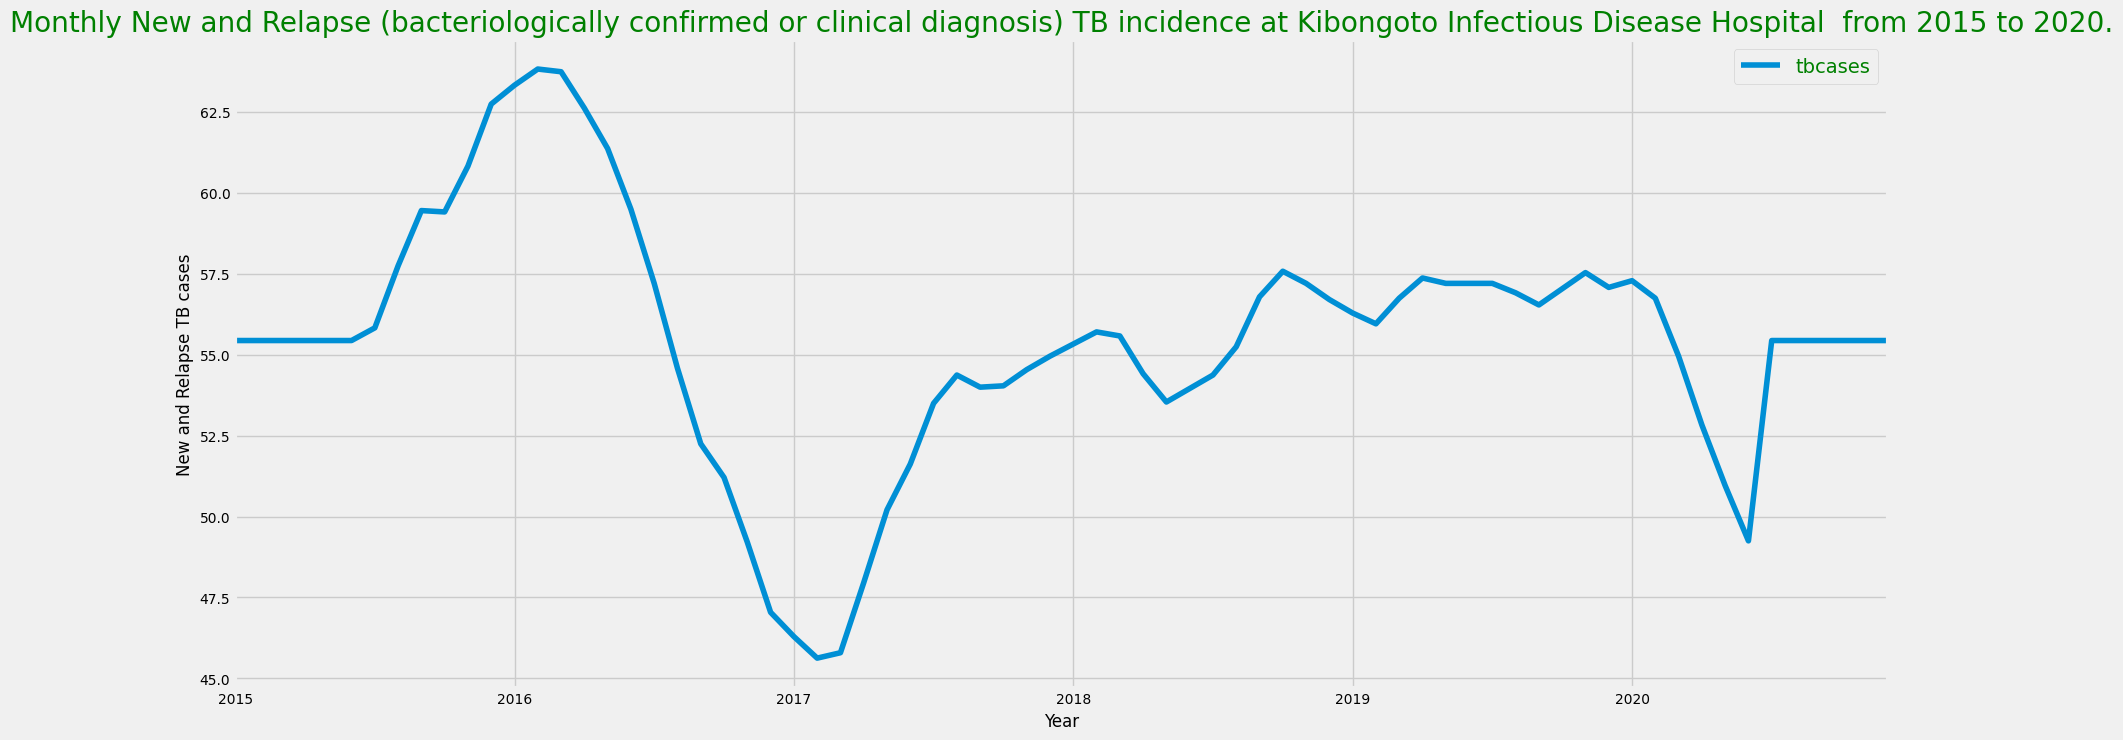

In [1968]:
series.plot(figsize = (19, 8),title="Monthly New and Relapse (bacteriologically confirmed or clinical diagnosis) TB incidence at Kibongoto Infectious Disease Hospital  from 2015 to 2020.",ylabel="New and Relapse TB cases",xlabel="Year")
plt.show()

In [1969]:
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataset = series.values
dataset = dataset.astype('float32')

In [1970]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)




In [1971]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [1972]:
testX.shape

(19, 2, 1)

CREATE MODEL AND FITS

In [1973]:
batch_size = 1
model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, look_back, 1), stateful=True,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

47/47 - 3s - loss: 0.2731
47/47 - 0s - loss: 0.1032
47/47 - 0s - loss: 0.0910
47/47 - 0s - loss: 0.0764
47/47 - 0s - loss: 0.0746
47/47 - 0s - loss: 0.0582
47/47 - 0s - loss: 0.0516
47/47 - 0s - loss: 0.0577
47/47 - 0s - loss: 0.0507
47/47 - 0s - loss: 0.0477
47/47 - 0s - loss: 0.0359
47/47 - 0s - loss: 0.0305
47/47 - 0s - loss: 0.0337
47/47 - 0s - loss: 0.0348
47/47 - 0s - loss: 0.0344
47/47 - 0s - loss: 0.0280
47/47 - 0s - loss: 0.0325
47/47 - 0s - loss: 0.0314
47/47 - 0s - loss: 0.0269
47/47 - 0s - loss: 0.0229
47/47 - 0s - loss: 0.0182
47/47 - 0s - loss: 0.0262
47/47 - 0s - loss: 0.0165
47/47 - 0s - loss: 0.0191
47/47 - 0s - loss: 0.0207
47/47 - 0s - loss: 0.0243
47/47 - 0s - loss: 0.0177
47/47 - 0s - loss: 0.0161
47/47 - 0s - loss: 0.0191
47/47 - 0s - loss: 0.0237
47/47 - 0s - loss: 0.0143
47/47 - 0s - loss: 0.0097
47/47 - 0s - loss: 0.0116
47/47 - 0s - loss: 0.0121
47/47 - 0s - loss: 0.0131
47/47 - 0s - loss: 0.0149
47/47 - 0s - loss: 0.0115
47/47 - 0s - loss: 0.0099
47/47 - 0s -

In [1974]:
# make forecast
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)


In [1975]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

EVALUATE A MODEL

TRAINING PERFOMANCE METRIC

In [1976]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast)  # MAPE
    mse=mean_squared_error(actual, forecast, squared=False)
    mae = mean_absolute_error(actual, forecast)    # MAE   # MPE
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    r2=r2_score(actual, forecast)  # RMSE
    return({'mape':mape,  'mae': mae, "mse":mse,
             'rmse':rmse,'r2_score':r2})

forecast_accuracy(trainPredict[:,0],trainY[0])

{'mae': 0.6102635855726537,
 'mape': 0.01105218957041461,
 'mse': 0.764634929089913,
 'r2_score': 0.971570249530725,
 'rmse': 0.764634929089913}

TESTING PERFOMANCE METRIC

In [1977]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast)  # MAPE
    mse=mean_squared_error(actual, forecast, squared=False)
    mae = mean_absolute_error(actual, forecast)    # MAE   # MPE
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    r2=r2_score(actual, forecast)  # RMSE
    return({'mape':mape,  'mae': mae, "mse":mse,
             'rmse':rmse,'r2_score':r2})

forecast_accuracy(testPredict[:,0],testY[0])

{'mae': 1.078431980068939,
 'mape': 0.019657355435524725,
 'mse': 1.7359275506648515,
 'r2_score': 0.3821193254862847,
 'rmse': 1.7359275506648515}

TESTING

In [1978]:
import pandas as pd

import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

from keras.models import Sequential

from keras.layers import Dense

from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

from keras.layers import LSTM

In [1979]:
series

,tbcases
Date,
2015-01-01,55.441667
2015-02-01,55.441667
2015-03-01,55.441667
2015-04-01,55.441667
2015-05-01,55.441667
...,...
2020-08-01,55.441667
2020-09-01,55.441667
2020-10-01,55.441667


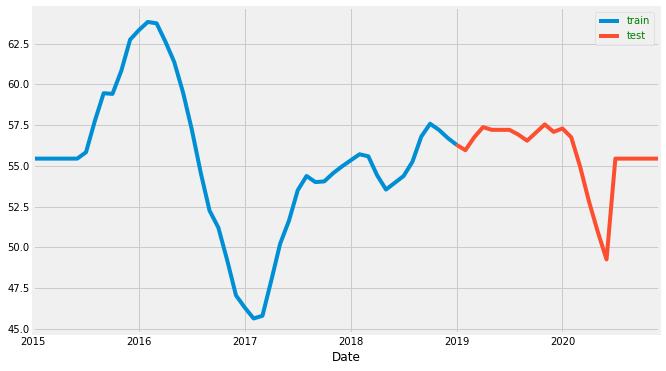

In [1980]:
split_date = pd.Timestamp('2019-01-01')

df =  series['tbcases']

train = df.loc[:split_date]

test = df.loc[split_date:]

plt.figure(figsize=(10, 6))

ax = train.plot()

test.plot(ax=ax)

plt.legend(['train', 'test']);

In [1981]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train=train.values
train=train.reshape(-1,1)
train_sc = scaler.fit_transform(train)
test=test.values
test=test.reshape(-1,1)
test_sc = scaler.transform(test)



In [1982]:
X_train = train_sc[:-1]

y_train = train_sc[1:]



X_test = test_sc[:-1]

y_test = test_sc[1:]

In [1983]:
nn_model = Sequential()

nn_model.add(Dense(512, input_dim=1, activation='tanh'))
nn_model.add(Dense(512, input_dim=1, activation='tanh'))
nn_model.add(Dense(1))

nn_model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
48/48 [==============================] - 1s 2ms/step - loss: 0.0610
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1877
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0974
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 00005: early stopping


In [1984]:
y_pred_test_nn = nn_model.predict(X_test)

y_train_pred_nn = nn_model.predict(X_train)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.784
The R2 score on the Test set is:	0.409


In [1985]:
X_train_lmse = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lmse = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lst = Sequential()
lst.add(LSTM(512, input_shape=(1, X_train_lmse.shape[1]), activation='tanh', kernel_initializer='lecun_uniform', return_sequences=False))
lst.add(Dense(1))
lst.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lst.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/100
48/48 [==============================] - 2s 7ms/step - loss: 0.0453
Epoch 2/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0540
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0256
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0329
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0491
Epoch 00005: early stopping


In [1986]:
y_pred_test_lstm = lst.predict(X_test_lmse)
y_train_pred_lstm = lst.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))


The R2 score on the Train set is:	0.773
The R2 score on the Test set is:	-0.292


In [1987]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast)  # MAPE
    mse=mean_squared_error(actual, forecast, squared=False)
    mae = mean_absolute_error(actual, forecast)    # MAE   # MPE
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    r2=r2_score(actual, forecast)  # RMSE
    return({'mape':mape,  'mae': mae, "mse":mse,
             'rmse':rmse,'r2_score':r2})

forecast_accuracy(y_pred_test_lstm,y_test)

{'mae': 0.19294136014409344,
 'mape': 1.8570971741116542,
 'mse': 0.25639147848208177,
 'r2_score': -0.29225858802849536,
 'rmse': 0.25639147848208177}